# Quantised SqueezeNet

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.jit as jit
import torch.backends.cudnn as cudnn

from torch.autograd import Variable

In [2]:
# Remember to:
!export PYTHONPATH=$(readlink -m ./pytorch-playground):$PYTHONPATH
from utee import misc, quant, selector
from imagenet import squeezenet
from collections import OrderedDict

In [3]:
gpu = misc.auto_select_gpu(utility_bound=0, num_gpu=1, selected_gpus='0')
ngpu = len(gpu)
input_size = 224

batch_size = 100
data_root='/tmp/public_dataset/pytorch/'

assert torch.cuda.is_available(), 'no cuda'
torch.manual_seed(117)
torch.cuda.manual_seed(117)

# load model and dataset fetcher
model_raw, ds_fetcher, is_imagenet = selector.select('squeezenet_v1', model_root='~/.torch/models')

Setting GPU: ['0']
Building and initializing squeezenet_v1 parameters


In [40]:
# eval model
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1, acc5 = misc.eval_model(model_raw, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader, 50000 for train, 50000 for test


=> Done (6.2928 s)

 62%|██████▏   | 309/500 [00:46<00:28,  6.62it/s]


100%|█████████▉| 499/500 [01:15<00:00,  6.59it/s]


In [41]:
# This is the accuracy at fp32
acc1, acc5

(0.55948, 0.7913)

# Collect activation statistics

In [12]:
class Logger(nn.Module):
    def __init__(self, name):
        super(Logger, self).__init__()
        self.name = name
        self.log_items = []
        #self.percentiles = torch.zeros(1, 5).cuda()
        #self.indices = None
        
    def forward(self, x):
        # Slowwwwwww (7s/it)
        #log_item = np.percentile(x.data.cpu().numpy(), q=[float(x) for x in [0, 5, 95, 100]])
        # (~4.9it/s)
        #log_item = (torch.min(x).data.cpu().numpy()[0],
        #            torch.max(x).data.cpu().numpy()[0])
        # histc not implemented on cuda
        #log_item = torch.histc(x, bins=100).cpu().numpy()
        
        #if self.indices is None:
        #    length = x.data.view(-1).size()[0]
        #    self.indices = torch.LongTensor([int(float(p)/1000*length) for p in range(0,1001)]).cuda()
        
        sorted, _indices = torch.sort(x.data.view(-1))
        #prow = torch.index_select(sorted, 0, self.indices)
        #self.percentiles = torch.cat((self.percentiles, prow))
        #del sorted
        #del prow
        
        
        self.log_items.append(log_item)
        return x
    
import copy
def duplicate_model_with_logging(model, indent_level=0):
    """
    Inserts logging nodes into a NN model.
    
    Assumes that original model has at least a nn.Sequential.
    """
    loggers = []
    indent = " " * indent_level
    if isinstance(model, nn.Sequential):
        print(f'{indent}Sequential')
        l = OrderedDict()
        if indent_level == 0:
            l["input_log"] = Logger("input")
        for k, v in model._modules.items():
            print(f'{indent} Looking at : {k}')
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
                l[k] = v
                logger = Logger(k)
                l[f'{k}_log'] = logger
                loggers.append(logger)
            else:
                l[k], subloggers = duplicate_model_with_logging(v, indent_level + 1)
                loggers.extend(subloggers)
        m = nn.Sequential(l)
        return m, loggers
    else:
        print(f'{indent}Not Sequential')
        model = model #if indent_level > 0 else copy.deepcopy(model)
        for k, v in model._modules.items():
            model._modules[k], subloggers = duplicate_model_with_logging(v)
            loggers.extend(subloggers)
        return model, loggers

In [13]:
model_log, loggers = duplicate_model_with_logging(model_raw)

Not Sequential
Sequential
 Looking at : 0
 Looking at : 1
 Not Sequential
 Looking at : 2
 Not Sequential
 Looking at : 3
 Not Sequential
Sequential
 Looking at : squeeze
 Looking at : squeeze_activation
 Not Sequential
Sequential
 Looking at : expand1x1
 Looking at : expand1x1_activation
 Not Sequential
Sequential
 Looking at : expand3x3
 Looking at : expand3x3_activation
 Not Sequential
 Looking at : 4
 Not Sequential
Sequential
 Looking at : squeeze
 Looking at : squeeze_activation
 Not Sequential
Sequential
 Looking at : expand1x1
 Looking at : expand1x1_activation
 Not Sequential
Sequential
 Looking at : expand3x3
 Looking at : expand3x3_activation
 Not Sequential
 Looking at : 5
 Not Sequential
 Looking at : 6
 Not Sequential
Sequential
 Looking at : squeeze
 Looking at : squeeze_activation
 Not Sequential
Sequential
 Looking at : expand1x1
 Looking at : expand1x1_activation
 Not Sequential
Sequential
 Looking at : expand3x3
 Looking at : expand3x3_activation
 Not Sequential
 Loo

In [7]:
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1, acc5 = misc.eval_model(model_log, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)

Not Sequential


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/THCTensorCopy.cu:100

In [14]:
str(nn.Module().__class__)

"<class 'torch.nn.modules.module.Module'>"

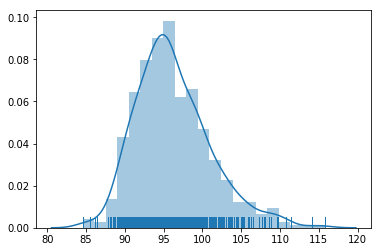

In [48]:
import seaborn as sbs
data = np.asarray(loggers[1].log_items)
sbs.distplot(data[:,1] - data[:,0], hist=True, rug=True)

In [53]:
np.percentile(data, q=[0, 1, 5, 95, 99, 100], axis=0)

array([[-64.68961334,  37.50022125],
       [-59.58321198,  37.99289818],
       [-57.89531536,  39.38270359],
       [-48.49136219,  49.74721947],
       [-47.57300343,  51.59901909],
       [-46.29519653,  56.11297226]])

In [70]:
[0,1,2,3,4,5][[0,2]]

TypeError: list indices must be integers or slices, not list

# Modifying for quantised inference

In [42]:
# model.apply(f) calls f for each Module in the model.
#  But it doesn't handle things like torch.concat
model_raw.apply(lambda m: print(type(m)))

# Can copy a model with:
import copy
copy.deepcopy(model_raw)
# Or just recreate the model:
model_copy = create_model()
model_copy.lead_state_dict(original_model.state_dict())



<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'imagenet.squeezenet.Fire'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'imagenet.squeezenet.Fire'>
<class 'torch.nn.module

SqueezeNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire(
      (group1): Sequential(
        (squeeze): Conv2d (64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
      )
      (group2): Sequential(
        (expand1x1): Conv2d (16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
      )
      (group3): Sequential(
        (expand3x3): Conv2d (16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace)
      )
    )
    (4): Fire(
      (group1): Sequential(
        (squeeze): Conv2d (128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
      )
      (group2): Sequential(
        (expand1x1): Conv2d (16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
  

In [58]:
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
(data, target) = next(val_ds)
data = Variable(torch.FloatTensor(data)).cuda()
model_cuda = torch.nn.DataParallel(model_raw.eval(), device_ids=range(ngpu)).cuda()
trace, out = jit.trace(model_cuda, data)

Loading pickle object from /tmp/public_dataset/pytorch/imagenet-data/val224.pkl


Building IMAGENET data loader, 50000 for train, 50000 for test


=> Done (6.3597 s)


In [65]:
trace.graph()

graph(%1 : Float(100, 3, 224, 224)
      %2 : Float(64, 3, 3, 3)
      %3 : Float(64)
      %4 : Float(16, 64, 1, 1)
      %5 : Float(16)
      %6 : Float(64, 16, 1, 1)
      %7 : Float(64)
      %8 : Float(64, 16, 3, 3)
      %9 : Float(64)
      %10 : Float(16, 128, 1, 1)
      %11 : Float(16)
      %12 : Float(64, 16, 1, 1)
      %13 : Float(64)
      %14 : Float(64, 16, 3, 3)
      %15 : Float(64)
      %16 : Float(32, 128, 1, 1)
      %17 : Float(32)
      %18 : Float(128, 32, 1, 1)
      %19 : Float(128)
      %20 : Float(128, 32, 3, 3)
      %21 : Float(128)
      %22 : Float(32, 256, 1, 1)
      %23 : Float(32)
      %24 : Float(128, 32, 1, 1)
      %25 : Float(128)
      %26 : Float(128, 32, 3, 3)
      %27 : Float(128)
      %28 : Float(48, 256, 1, 1)
      %29 : Float(48)
      %30 : Float(192, 48, 1, 1)
      %31 : Float(192)
      %32 : Float(192, 48, 3, 3)
      %33 : Float(192)
      %34 : Float(48, 384, 1, 1)
      %35 : Float(48)
      %36 : Float(192, 48, 1, 1)
      

In [62]:
print(trace)

graph(%1 : Float(100, 3, 224, 224)
      %2 : Float(64, 3, 3, 3)
      %3 : Float(64)
      %4 : Float(16, 64, 1, 1)
      %5 : Float(16)
      %6 : Float(64, 16, 1, 1)
      %7 : Float(64)
      %8 : Float(64, 16, 3, 3)
      %9 : Float(64)
      %10 : Float(16, 128, 1, 1)
      %11 : Float(16)
      %12 : Float(64, 16, 1, 1)
      %13 : Float(64)
      %14 : Float(64, 16, 3, 3)
      %15 : Float(64)
      %16 : Float(32, 128, 1, 1)
      %17 : Float(32)
      %18 : Float(128, 32, 1, 1)
      %19 : Float(128)
      %20 : Float(128, 32, 3, 3)
      %21 : Float(128)
      %22 : Float(32, 256, 1, 1)
      %23 : Float(32)
      %24 : Float(128, 32, 1, 1)
      %25 : Float(128)
      %26 : Float(128, 32, 3, 3)
      %27 : Float(128)
      %28 : Float(48, 256, 1, 1)
      %29 : Float(48)
      %30 : Float(192, 48, 1, 1)
      %31 : Float(192)
      %32 : Float(192, 48, 3, 3)
      %33 : Float(192)
      %34 : Float(48, 384, 1, 1)
      %35 : Float(48)
      %36 : Float(192, 48, 1, 1)
      

In [32]:
# We do dumb quantisation; no fine-tuning.

weights_bw    = 8
biases_bw     = 32
activation_bw = 8
overflow_rate = 0.0
n_sample      = 20
quant_method  = "linear"
    
def duplicate_model_with_quant(model, bits, overflow_rate=0.0, counter=10, type='linear'):
    """assume that original model has at least a nn.Sequential"""
    assert type in ['linear', 'minmax', 'log', 'tanh']
    if isinstance(model, nn.Sequential):
        print(f'> Sequential')
        l = OrderedDict()
        for k, v in model._modules.items():
            print(f'Looking at : {k}')
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm1d, nn.BatchNorm2d, nn.AvgPool2d)):
                parameters = list(v.parameters())
                if isinstance(v, nn.Conv2d):
                    print(f"Found Conv2D:")
                    print(f"  weights: [o,i,k,k] {parameters[0].shape}")
                    print(f"  biases : [o] {parameters[1].shape}")
                l[k] = v
                
            else:
                l[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter, type)
        m = nn.Sequential(l)
        return m
    else:
        print(f'> Not Sequential')
        for k, v in model._modules.items():
            model._modules[k] = duplicate_model_with_quant(v, bits, overflow_rate, counter, type)
        return model

model_quant = duplicate_model_with_quant(model_raw, bits=activation_bw, overflow_rate=overflow_rate,
                                               counter=n_sample, type=quant_method)

> Not Sequential
> Sequential
Looking at : 0
Found Conv2D:
  weights: [o,i,k,k] torch.Size([64, 3, 3, 3])
  biases : [o] torch.Size([64])
Looking at : 0_linear_quant
> Not Sequential
Looking at : 1
> Not Sequential
Looking at : 2
> Not Sequential
Looking at : 3
> Not Sequential
> Sequential
Looking at : squeeze
Found Conv2D:
  weights: [o,i,k,k] torch.Size([16, 64, 1, 1])
  biases : [o] torch.Size([16])
Looking at : squeeze_linear_quant
> Not Sequential
Looking at : squeeze_activation
> Not Sequential
> Sequential
Looking at : expand1x1
Found Conv2D:
  weights: [o,i,k,k] torch.Size([64, 16, 1, 1])
  biases : [o] torch.Size([64])
Looking at : expand1x1_linear_quant
> Not Sequential
Looking at : expand1x1_activation
> Not Sequential
> Sequential
Looking at : expand3x3
Found Conv2D:
  weights: [o,i,k,k] torch.Size([64, 16, 3, 3])
  biases : [o] torch.Size([64])
Looking at : expand3x3_linear_quant
> Not Sequential
Looking at : expand3x3_activation
> Not Sequential
Looking at : 4
> Not Sequ

In [ ]:
# eval model
val_ds = ds_fetcher(batch_size, data_root=data_root, train=False, input_size=input_size)
acc1q, acc5q = misc.eval_model(model_quant, val_ds, ngpu=ngpu, is_imagenet=is_imagenet)

In [25]:
acc1q, acc5q

NameError: name 'acc1q' is not defined

# Exporting model
There is the existing ONNX exporter. Either modify that, or manually add functions to each type of Module and call them recursively.

# Modifying for quantised training
Easiest would be to modify SqN source.

## MobileNet
Search GitHub; there seem to be plenty of implementations. E.g. https://github.com/marvis/pytorch-mobilenet
There are also implementations for v2.

## MobileNet-SSD
Try modifying https://github.com/amdegroot/ssd.pytorch:
  - Use MobileNet feature extractor
  - Use dw convolutions in SSD (SSDLite)

In [8]:
model_raw.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.group1.squeeze.weight', 'features.3.group1.squeeze.bias', 'features.3.group2.expand1x1.weight', 'features.3.group2.expand1x1.bias', 'features.3.group3.expand3x3.weight', 'features.3.group3.expand3x3.bias', 'features.4.group1.squeeze.weight', 'features.4.group1.squeeze.bias', 'features.4.group2.expand1x1.weight', 'features.4.group2.expand1x1.bias', 'features.4.group3.expand3x3.weight', 'features.4.group3.expand3x3.bias', 'features.6.group1.squeeze.weight', 'features.6.group1.squeeze.bias', 'features.6.group2.expand1x1.weight', 'features.6.group2.expand1x1.bias', 'features.6.group3.expand3x3.weight', 'features.6.group3.expand3x3.bias', 'features.7.group1.squeeze.weight', 'features.7.group1.squeeze.bias', 'features.7.group2.expand1x1.weight', 'features.7.group2.expand1x1.bias', 'features.7.group3.expand3x3.weight', 'features.7.group3.expand3x3.bias', 'features.9.group1.squeeze.weight', 'features.9.group1.squeeze.bias', 'featu

In [1]:
[1,2,3][:1]

[1]